In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer

from sklearn.impute import KNNImputer




from predicting_odor_from_molecular_structure import *


df = goodscents()
df

,TGSC ID,CID,Concentration %,Solvent,MolecularWeight,IsomericSMILES,IUPACName,name,Labels
0,1000111,7476,100.0,NaN,150.17,CC(=O)C1=CC=C(C=C1)OC,1-(4-methoxyphenyl)ethanone,4'-methoxyacetophenone,"[sweet, vanilla, cherry maraschino cherry, pow..."
1,1031871,7478,10.0,dipropylene glycol,152.15,COC1=CC=C(C=C1)C(=O)O,4-methoxybenzoic acid,4-methoxybenzoic acid,"[phenolic, animal, fecal, medicinal]"
2,1009281,7501,0.1,triacetin,104.15,C=CC1=CC=CC=C1,styrene,styrene,"[sweet, plastic, floral, balsamic]"
3,1001651,244,100.0,NaN,108.14,C1=CC=C(C=C1)CO,phenylmethanol,benzyl alcohol,"[sweet, floral, rose, fruity, phenolic, balsam..."
4,1001491,240,10.0,dipropylene glycol,106.12,C1=CC=C(C=C1)C=O,benzaldehyde,benzaldehyde,"[sweet, cherry, cherry maraschino cherry, nutt..."
...,...,...,...,...,...,...,...,...,...
4621,1020461,11564539,NaN,NaN,170.29,CCCCCCCC(=C)C(C)O,3-methylidenedecan-2-ol,3-methylidenedecan-2-ol,"[flowers, orange]"
4622,1027261,46195361,1.0,dipropylene glycol,146.25,CCC1OCCC(S1)C,"2-ethyl-4-methyl-1,3-oxathiane",schembl2678282,"[vegetable, floral, fruity, apricot, green, tr..."
4623,1028151,46195364,0.1,propylene glycol,174.31,CCCCC1OCCC(S1)C,"2-butyl-4-methyl-1,3-oxathiane",schembl2676606,"[spicy, leafy, peppery, banana, fruity, oily, ..."
4624,1554361,88571201,NaN,NaN,114.19,CC[C@@H](C)CCC=O,(4R)-4-methylhexanal,(r)-4-methylhexanal,"[flowery, fresh, green, warm]"


In [2]:
df = reduce_df(df, minimum=30)
df.shape

(4506, 9)

### Featurization

In [4]:
dfx = create_all_features(df)
dfx

,TGSC ID,CID,Concentration %,Solvent,MolecularWeight,IsomericSMILES,IUPACName,name,Labels,mol,morgan_fp,daylight_fp
0,1000111,7476,100.0,NaN,150.17,CC(=O)C1=CC=C(C=C1)OC,1-(4-methoxyphenyl)ethanone,4'-methoxyacetophenone,"[sweet, vanilla, powdery, anisic, balsamic, ha...",<rdkit.Chem.rdchem.Mol object at 0x0000020326F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1031871,7478,10.0,dipropylene glycol,152.15,COC1=CC=C(C=C1)C(=O)O,4-methoxybenzoic acid,4-methoxybenzoic acid,"[phenolic, animal, medicinal]",<rdkit.Chem.rdchem.Mol object at 0x0000020326F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1009281,7501,0.1,triacetin,104.15,C=CC1=CC=CC=C1,styrene,styrene,"[sweet, floral, balsamic]",<rdkit.Chem.rdchem.Mol object at 0x0000020326F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1001651,244,100.0,NaN,108.14,C1=CC=C(C=C1)CO,phenylmethanol,benzyl alcohol,"[sweet, floral, rose, fruity, phenolic, balsam...",<rdkit.Chem.rdchem.Mol object at 0x0000020326F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1001491,240,10.0,dipropylene glycol,106.12,C1=CC=C(C=C1)C=O,benzaldehyde,benzaldehyde,"[sweet, cherry, nutty, fruity, powdery, almond...",<rdkit.Chem.rdchem.Mol object at 0x0000020326F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4621,1020461,11564539,NaN,NaN,170.29,CCCCCCCC(=C)C(C)O,3-methylidenedecan-2-ol,3-methylidenedecan-2-ol,[orange],<rdkit.Chem.rdchem.Mol object at 0x00000203283...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4622,1027261,46195361,1.0,dipropylene glycol,146.25,CCC1OCCC(S1)C,"2-ethyl-4-methyl-1,3-oxathiane",schembl2678282,"[vegetable, floral, fruity, apricot, green, tr...",<rdkit.Chem.rdchem.Mol object at 0x00000203283...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4623,1028151,46195364,0.1,propylene glycol,174.31,CCCCC1OCCC(S1)C,"2-butyl-4-methyl-1,3-oxathiane",schembl2676606,"[spicy, leafy, peppery, banana, fruity, oily, ...",<rdkit.Chem.rdchem.Mol object at 0x00000203283...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4624,1554361,88571201,NaN,NaN,114.19,CC[C@@H](C)CCC=O,(4R)-4-methylhexanal,(r)-4-methylhexanal,"[fresh, green, warm]",<rdkit.Chem.rdchem.Mol object at 0x00000203283...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
mordred = create_mordred_features(dfx)
mordred

100%|██████████| 4506/4506 [00:52<00:00, 85.04it/s] 


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,7.956514,7.451864,0,0,13.619695,2.250875,4.501749,13.619695,1.238154,3.286693,...,8.906935,40.567492,150.068080,7.146099,162,13,50.0,55.0,4.583333,2.611111
1,7.956514,7.451864,1,0,13.619695,2.250875,4.501749,13.619695,1.238154,3.286693,...,8.906935,40.567492,152.047344,8.002492,162,13,50.0,55.0,4.583333,2.611111
2,5.656854,5.427660,0,0,10.424292,2.135779,4.271558,10.424292,1.303037,2.969338,...,8.298291,35.247635,104.062600,6.503913,64,7,34.0,36.0,2.611111,2.000000
3,5.656854,5.427660,0,0,10.424292,2.135779,4.271558,10.424292,1.303037,2.969338,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
4,5.656854,5.427660,0,0,10.424292,2.135779,4.271558,10.424292,1.303037,2.969338,...,8.298291,35.247635,106.041865,7.574419,64,7,34.0,36.0,2.611111,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621,8.065904,7.893227,0,0,13.812926,2.092177,4.184353,13.812926,1.151077,3.306818,...,8.302266,40.156271,170.167065,5.004914,256,11,46.0,46.0,5.722222,3.027778
4622,6.473351,6.191587,0,0,11.142106,2.200122,4.400244,11.142106,1.238012,3.089776,...,8.606851,37.313444,146.076536,6.351154,88,9,40.0,43.0,3.472222,2.166667
4623,7.887564,7.276324,0,0,13.649148,2.212234,4.424468,13.649148,1.240832,3.278334,...,8.711608,40.046626,174.107836,6.003718,170,11,48.0,51.0,3.972222,2.666667
4624,5.059137,5.436502,0,0,9.40926,1.989044,3.978088,9.40926,1.176158,2.88852,...,7.623153,33.372552,114.104465,5.186567,76,6,28.0,27.0,4.111111,2.166667


In [ ]:

mordred_features_clean = mordred.dropna(axis=1, thresh=int(0.8*len(dfx)))
imputer = KNNImputer()
mordred_imputed = imputer.fit_transform(mordred_features_clean)
mordred_imputed

array([[ 7.95651408,  7.45186446,  0.        , ..., 55.        ,
         4.58333333,  2.61111111],
       [ 7.95651408,  7.45186446,  1.        , ..., 55.        ,
         4.58333333,  2.61111111],
       [ 5.65685425,  5.42766007,  0.        , ..., 36.        ,
         2.61111111,  2.        ],
       ...,
       [ 7.88756439,  7.27632423,  0.        , ..., 51.        ,
         3.97222222,  2.66666667],
       [ 5.05913727,  5.43650183,  0.        , ..., 27.        ,
         4.11111111,  2.16666667],
       [ 5.05913727,  5.43650183,  0.        , ..., 27.        ,
         4.11111111,  2.16666667]])

### Training

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

classes = label_frequencies(df, labels_column='Labels').Label.to_list()
mlb = MultiLabelBinarizer(classes=classes)
Y = mlb.fit_transform(df['Labels'])

mlb, Y.shape

(MultiLabelBinarizer(classes=['fruity', 'green', 'sweet', 'floral', 'woody',
                              'herbal', 'fatty', 'fresh', 'waxy', 'spicy',
                              'citrus', 'rose', 'sulfurous', 'earthy', 'nutty',
                              'tropical', 'odorless', 'balsamic', 'oily',
                              'minty', 'vegetable', 'powdery', 'musty', 'meaty',
                              'creamy', 'pineapple', 'apple', 'aldehydic',
                              'roasted', 'phenolic', ...]),
 (4506, 133))

In [ ]:
# Morgan i Daylight już są jako listy 0/1 w df
X_morgan = np.array(df['morgan_fp'].tolist())
X_daylight = np.array(df['daylight_fp'].tolist())


feature_sets = {
    'Morgan': X_morgan,
    'Daylight': X_daylight,
    'Mordred': mordred_imputed,
}


feature_sets


{'Morgan': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]),
 'Daylight': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'Mordred': array([[ 7.95651408,  7.45186446,  0.        , ..., 55.        ,
          4.58333333,  2.61111111],
        [ 7.95651408,  7.45186446,  1.        , ..., 55.        ,
          4.58333333,  2.61111111],
        [ 5.65685425,  5.42766007,  0.        , ..., 36.        ,
          2.61111111,  2.        ],
        ...,
        [ 7.88756439,  7.27632423,  0.        , ..., 51.        ,
          3.97222222,  2.66666667],
        [ 5.05913727,  5.43650183,  0.        , ..., 27.        ,
          4.11111111,  2.16666667],
        [ 5.059137

In [14]:
for k, v in feature_sets.items():
    print(v.shape)

(4506, 2048)
(4506, 2048)
(4506, 1539)


In [15]:
indices = np.arange(len(df))
# Dodaj indeks jako ostatnią kolumnę do cech (np. Mordred)
X_with_idx = np.concatenate([mordred_imputed, indices.reshape(-1, 1)], axis=1)
X_train, y_train, X_test, y_test = iterative_train_test_split(X_with_idx, Y, test_size=0.2)
train_indices = X_train[:, -1].astype(int)
test_indices = X_test[:, -1].astype(int)

def get_split(X, train_idx, test_idx):
    return X[train_idx], X[test_idx]


In [52]:

from sklearn.neighbors import KNeighborsClassifier


# model_types = {
#     'RF': lambda: RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
#     'Chain': lambda: ClassifierChain(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
# }

model_types = {
    'RF': lambda: RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    #'Chain': lambda: ClassifierChain(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    'KNN': lambda: KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

results = []
models = {}

for feat_name, X in feature_sets.items():
    X_train_, X_test_ = get_split(X, train_indices, test_indices)
    for model_name, model_init in model_types.items():
        key = f"{feat_name}_{model_name}"
        print(f"Trenuję {key} ...")
        model = model_init()
        model.fit(X_train_, y_train)
        y_pred = model.predict(X_test_)
        if hasattr(y_pred, "toarray"):
            y_pred = y_pred.toarray()
        # Metryki per-label
        precision = precision_score(y_test, y_pred, average=None, zero_division=0)
        recall = recall_score(y_test, y_pred, average=None, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
        results.append({
            'model': key,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        # Zapisz wytrenowany model i predykcje do późniejszej inferencji
        models[key] = {
            'model': model,
            'y_pred': y_pred,
            'X_test': X_test_,
            'y_test': y_test,
            'test_indices': test_indices
        }



Trenuję Morgan_RF ...
Trenuję Morgan_KNN ...
Trenuję Daylight_RF ...
Trenuję Daylight_KNN ...
Trenuję Mordred_RF ...
Trenuję Mordred_KNN ...


In [53]:
import numpy as np
import pandas as pd


summary_stats = []

for model_key, model_data in models.items():
    y_test = model_data['y_test']
    y_pred = model_data['y_pred']

    # Probabilistyczne predykcje do ROC-AUC (jeśli model obsługuje)
    y_proba = None
    try:
        if hasattr(model_data['model'], "predict_proba"):
            y_proba_list = model_data['model'].predict_proba(model_data['X_test'])
            if isinstance(y_proba_list, list) or isinstance(y_proba_list, tuple):
                y_proba = np.stack([p[:, 1] for p in y_proba_list], axis=1)
            else:
                y_proba = y_proba_list
    except Exception:
        y_proba = None

    # Metryki dla całego zbioru
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    # ROC-AUC macro
    try:
        if y_proba is not None:
            roc_auc_macro = roc_auc_score(y_test, y_proba, average='macro')
        else:
            roc_auc_macro = np.nan
    except Exception:
        roc_auc_macro = np.nan

    summary_stats.append({
        'model': model_key,
        'roc_auc_macro': roc_auc_macro,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro
    })

summary_df = pd.DataFrame(summary_stats)
summary_df


,model,roc_auc_macro,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro
0,Morgan_RF,0.788106,0.281788,0.154273,0.530093,0.364927,0.191899,0.106740
1,Morgan_KNN,0.688624,0.281047,0.139345,0.475683,0.291240,0.199441,0.103812
2,Daylight_RF,0.778569,0.315614,0.195904,0.468389,0.337531,0.237989,0.148193
3,Daylight_KNN,0.693909,0.299115,0.146438,0.459225,0.266349,0.221788,0.114911
4,Mordred_RF,0.823979,0.288213,0.156316,0.566285,0.389397,0.193296,0.107570
5,Mordred_KNN,0.662164,0.233913,0.089155,0.424376,0.188684,0.161453,0.065845


### Inference

In [55]:
model_key = 'Morgan_KNN'  # dowolny z 6
m = models[model_key]
sample_indices = np.random.choice(len(m['test_indices']), size=5, replace=False)
for idx in sample_indices:
    original_idx = m['test_indices'][idx]
    molecule_name = df.iloc[original_idx]['name']
    true_labels = mlb.inverse_transform(m['y_test'][idx].reshape(1, -1))[0]
    pred_labels = mlb.inverse_transform(m['y_pred'][idx].reshape(1, -1))[0]
    print(f"Idx: {original_idx} | Nazwa: {molecule_name}")
    print(f"  Prawdziwe etykiety: {true_labels}")
    print(f"  Predykowane etykiety: {pred_labels}")
    print("-" * 40)

Idx: 851 | Nazwa: ethyl 3-acetoxy-2-methylbutanoate
  Prawdziwe etykiety: ('fruity',)
  Predykowane etykiety: ('fruity', 'sweet')
----------------------------------------
Idx: 1425 | Nazwa: 1,2-dihydroperillaldehyde
  Prawdziwe etykiety: ('fruity', 'herbal', 'spicy')
  Predykowane etykiety: ('pungent',)
----------------------------------------
Idx: 1355 | Nazwa: 2-(3-phenylpropyl)pyridine
  Prawdziwe etykiety: ('green', 'fresh', 'earthy', 'vegetable', 'metallic', 'cortex', 'weedy')
  Predykowane etykiety: ('green',)
----------------------------------------
Idx: 564 | Nazwa: 2-phenylethyl propionate
  Prawdziwe etykiety: ('fruity', 'floral', 'rose', 'honey')
  Predykowane etykiety: ('fruity', 'sweet', 'floral', 'rose')
----------------------------------------
Idx: 567 | Nazwa: 3-phenylpropyl propanoate
  Prawdziwe etykiety: ('fruity', 'floral', 'balsamic', 'hyacinth')
  Predykowane etykiety: ('fruity', 'sweet', 'floral')
----------------------------------------


In [58]:
model_key = 'Morgan_KNN'
idx = [r['model'] for r in results].index(model_key)
df_per_label = pd.DataFrame({
    'label': mlb.classes_,
    'precision': results[idx]['precision'],
    'recall': results[idx]['recall'],
    'f1': results[idx]['f1'],
})
df_per_label.head()

,label,precision,recall,f1
0,fruity,0.588235,0.520000,0.552017
1,green,0.529915,0.289720,0.374622
2,sweet,0.403509,0.343284,0.370968
3,floral,0.509804,0.428571,0.465672
4,woody,0.603448,0.253623,0.357143


In [59]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def compute_bootstrap_metric(y_true, y_pred, y_proba, metric_fn, n_bootstrap=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples = y_true.shape[0]
    vals = []
    for _ in range(n_bootstrap):
        idx = rng.choice(n_samples, size=n_samples, replace=True)
        yt = y_true[idx]
        yp = y_pred[idx]
        yp_proba = y_proba[idx] if y_proba is not None else None
        try:
            val = metric_fn(yt, yp if yp_proba is None else yp_proba)
        except Exception:
            val = np.nan
        vals.append(val)
    vals = np.array(vals)
    mean = np.nanmean(vals)
    lower = np.nanpercentile(vals, 2.5)
    upper = np.nanpercentile(vals, 97.5)
    return mean, lower, upper

results = []
models = {}

for feat_name, X in feature_sets.items():
    X_train_, X_test_ = get_split(X, train_indices, test_indices)
    for model_name, model_init in model_types.items():
        key = f"{feat_name}_{model_name}"
        print(f"Trenuję {key} ...")
        model = model_init()
        model.fit(X_train_, y_train)
        y_pred = model.predict(X_test_)
        if hasattr(y_pred, "toarray"):
            y_pred = y_pred.toarray()

        # Probabilistyczne predykcje (potrzebne do AUROC)
        y_proba = None
        try:
            if hasattr(model, "predict_proba"):
                y_proba_list = model.predict_proba(X_test_)
                if isinstance(y_proba_list, list) or isinstance(y_proba_list, tuple):
                    y_proba = np.stack([p[:, 1] for p in y_proba_list], axis=1)
                else:
                    y_proba = y_proba_list
        except Exception:
            y_proba = None

        # Funkcje do bootstrapa
        auroc_fn = lambda yt, yp_proba: roc_auc_score(yt, yp_proba, average='macro')
        precision_fn = lambda yt, yp: precision_score(yt, yp, average='macro', zero_division=0)
        recall_fn = lambda yt, yp: recall_score(yt, yp, average='macro', zero_division=0)
        f1_fn = lambda yt, yp: f1_score(yt, yp, average='macro', zero_division=0)

        # Licz metryki + 95% CI (bootstrap)
        if y_proba is not None:
            auroc_mean, auroc_lower, auroc_upper = compute_bootstrap_metric(y_test, y_pred, y_proba, auroc_fn)
        else:
            auroc_mean, auroc_lower, auroc_upper = np.nan, np.nan, np.nan
        precision_mean, precision_lower, precision_upper = compute_bootstrap_metric(y_test, y_pred, None, precision_fn)
        recall_mean, recall_lower, recall_upper = compute_bootstrap_metric(y_test, y_pred, None, recall_fn)
        f1_mean, f1_lower, f1_upper = compute_bootstrap_metric(y_test, y_pred, None, f1_fn)

        results.append({
            'model': key,
            'AUROC': f"{auroc_mean:.3f} [{auroc_lower:.3f}, {auroc_upper:.3f}]",
            'Precision': f"{precision_mean:.3f} [{precision_lower:.3f}, {precision_upper:.3f}]",
            'Recall': f"{recall_mean:.3f} [{recall_lower:.3f}, {recall_upper:.3f}]",
            'F1': f"{f1_mean:.3f} [{f1_lower:.3f}, {f1_upper:.3f}]"
        })

        # Zapisz wytrenowany model i predykcje do późniejszej inferencji
        models[key] = {
            'model': model,
            'y_pred': y_pred,
            'X_test': X_test_,
            'y_test': y_test,
            'test_indices': test_indices
        }

results_df = pd.DataFrame(results)
results_df


Trenuję Morgan_RF ...
Trenuję Morgan_KNN ...
Trenuję Daylight_RF ...
Trenuję Daylight_KNN ...
Trenuję Mordred_RF ...
Trenuję Mordred_KNN ...


,model,AUROC,Precision,Recall,F1
0,Morgan_RF,"0.788 [0.774, 0.801]","0.327 [0.284, 0.371]","0.107 [0.093, 0.124]","0.149 [0.130, 0.170]"
1,Morgan_KNN,"0.689 [0.676, 0.702]","0.261 [0.228, 0.295]","0.104 [0.091, 0.118]","0.135 [0.119, 0.151]"
2,Daylight_RF,"0.779 [0.765, 0.792]","0.323 [0.286, 0.361]","0.149 [0.130, 0.167]","0.190 [0.170, 0.211]"
3,Daylight_KNN,"0.694 [0.682, 0.707]","0.247 [0.215, 0.280]","0.115 [0.103, 0.129]","0.143 [0.128, 0.158]"
4,Mordred_RF,"0.824 [0.811, 0.836]","0.345 [0.300, 0.386]","0.108 [0.092, 0.124]","0.151 [0.131, 0.171]"
5,Mordred_KNN,"0.662 [0.650, 0.674]","0.173 [0.144, 0.201]","0.066 [0.057, 0.076]","0.087 [0.075, 0.099]"


In [60]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def show_nearest_neighbors(
    query_idx=None, 
    query_name=None, 
    X=None, 
    df=None, 
    n_neighbors=5, 
    feature_type='Morgan'
):
    """
    Pokazuje najbliższych sąsiadów dla wybranej cząsteczki.
    - query_idx: indeks cząsteczki w df
    - query_name: nazwa cząsteczki (kolumna 'name' w df)
    - X: macierz cech (np. feature_sets['Morgan'])
    - df: oryginalny DataFrame z kolumną 'name'
    - n_neighbors: ilu sąsiadów pokazać
    - feature_type: tylko do informacji w wypisie
    """
    if X is None or df is None:
        raise ValueError("Podaj X (macierz cech) i df (DataFrame z nazwami)!")
    if query_idx is None:
        if query_name is not None:
            query_idx = df.index[df['name'] == query_name].tolist()[0]
        else:
            raise ValueError("Podaj query_idx lub query_name!")
    # Dopasuj KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    dists, indices = knn.kneighbors([X[query_idx]])
    # Pomijamy pierwszy sąsiad (to zawsze cząsteczka sama do siebie)
    dists = dists[0][1:]
    indices = indices[0][1:]
    # Zbierz wyniki
    results = []
    for dist, idx in zip(dists, indices):
        row = df.iloc[idx]
        results.append({
            'idx': idx,
            'name': row['name'],
            'distance': dist,
            'labels': row['Labels']
        })
    results_df = pd.DataFrame(results)
    print(f"\nNajbliżsi sąsiedzi (cechy: {feature_type}) dla cząsteczki '{df.iloc[query_idx]['name']}' (idx={query_idx}):")
    display(results_df)
    return results_df

# Przykład użycia:
# Załóżmy, że masz feature_sets['Morgan'] i df z kolumną 'name'
# show_nearest_neighbors(query_name='benzaldehyde', X=feature_sets['Morgan'], df=df, n_neighbors=5, feature_type='Morgan')
# show_nearest_neighbors(query_idx=4, X=feature_sets['Mordred'], df=df, n_neighbors=5, feature_type='Mordred')


In [61]:
show_nearest_neighbors(query_name='benzaldehyde', X=feature_sets['Morgan'], df=df, n_neighbors=5, feature_type='Morgan')


Najbliżsi sąsiedzi (cechy: Morgan) dla cząsteczki 'benzaldehyde' (idx=4):


,idx,name,distance,labels
0,136,p-tolualdehyde,3.162278,"[phenolic, fruity, cherry]"
1,922,cinnamaldehyde,3.162278,"[sweet, spicy, cinnamon, warm]"
2,128,3-phenylprop-2-enal,3.162278,"[sweet, aldehydic, spicy, cinnamon, honey, pow..."
3,2,styrene,3.162278,"[sweet, floral, balsamic]"
4,2776,cis-cinnamaldehyde,3.162278,"[spicy, cinnamon]"


,idx,name,distance,labels
0,136,p-tolualdehyde,3.162278,"[phenolic, fruity, cherry]"
1,922,cinnamaldehyde,3.162278,"[sweet, spicy, cinnamon, warm]"
2,128,3-phenylprop-2-enal,3.162278,"[sweet, aldehydic, spicy, cinnamon, honey, pow..."
3,2,styrene,3.162278,"[sweet, floral, balsamic]"
4,2776,cis-cinnamaldehyde,3.162278,"[spicy, cinnamon]"


Wybrana cząsteczka: benzaldehyde
SMILES: C1=CC=C(C=C1)C=O


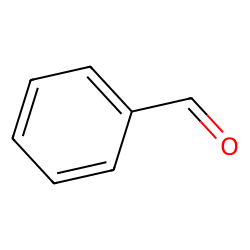


Najbliżsi sąsiedzi (cechy: Morgan) dla cząsteczki 'benzaldehyde' (idx=4):


,idx,name,distance,smiles,labels
0,136,p-tolualdehyde,3.162278,CC1=CC=C(C=C1)C=O,"[phenolic, fruity, cherry]"
1,922,cinnamaldehyde,3.162278,C1=CC=C(C=C1)/C=C/C=O,"[sweet, spicy, cinnamon, warm]"
2,128,3-phenylprop-2-enal,3.162278,C1=CC=C(C=C1)C=CC=O,"[sweet, aldehydic, spicy, cinnamon, honey, pow..."
3,2,styrene,3.162278,C=CC1=CC=CC=C1,"[sweet, floral, balsamic]"
4,2776,cis-cinnamaldehyde,3.162278,C1=CC=C(C=C1)/C=C\C=O,"[spicy, cinnamon]"


,idx,name,distance,smiles,labels
0,136,p-tolualdehyde,3.162278,CC1=CC=C(C=C1)C=O,"[phenolic, fruity, cherry]"
1,922,cinnamaldehyde,3.162278,C1=CC=C(C=C1)/C=C/C=O,"[sweet, spicy, cinnamon, warm]"
2,128,3-phenylprop-2-enal,3.162278,C1=CC=C(C=C1)C=CC=O,"[sweet, aldehydic, spicy, cinnamon, honey, pow..."
3,2,styrene,3.162278,C=CC1=CC=CC=C1,"[sweet, floral, balsamic]"
4,2776,cis-cinnamaldehyde,3.162278,C1=CC=C(C=C1)/C=C\C=O,"[spicy, cinnamon]"


In [62]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def show_nearest_neighbors_with_mol(
    query_idx=None, 
    query_name=None, 
    X=None, 
    df=None, 
    n_neighbors=5, 
    feature_type='Morgan'
):
    """
    Pokazuje najbliższych sąsiadów i rysuje cząsteczkę zapytania.
    - query_idx: indeks cząsteczki w df
    - query_name: nazwa cząsteczki (kolumna 'name' w df)
    - X: macierz cech (np. feature_sets['Morgan'])
    - df: oryginalny DataFrame z kolumną 'name', 'mol', 'IsomericSMILES'
    - n_neighbors: ilu sąsiadów pokazać
    - feature_type: tylko do informacji w wypisie
    """
    if X is None or df is None:
        raise ValueError("Podaj X (macierz cech) i df (DataFrame z nazwami)!")
    if query_idx is None:
        if query_name is not None:
            query_idx = df.index[df['name'] == query_name].tolist()[0]
        else:
            raise ValueError("Podaj query_idx lub query_name!")
    # Rysuj cząsteczkę zapytania
    mol = df.iloc[query_idx]['mol']
    smiles = df.iloc[query_idx]['IsomericSMILES']
    nazwa = df.iloc[query_idx]['name']
    print(f"Wybrana cząsteczka: {nazwa}")
    print(f"SMILES: {smiles}")
    display(Draw.MolToImage(mol, size=(250, 250)))
    # KNN
    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    dists, indices = knn.kneighbors([X[query_idx]])
    dists = dists[0][1:]
    indices = indices[0][1:]
    results = []
    for dist, idx in zip(dists, indices):
        row = df.iloc[idx]
        results.append({
            'idx': idx,
            'name': row['name'],
            'distance': dist,
            'smiles': row['IsomericSMILES'],
            'labels': row['Labels']
        })
    results_df = pd.DataFrame(results)
    print(f"\nNajbliżsi sąsiedzi (cechy: {feature_type}) dla cząsteczki '{nazwa}' (idx={query_idx}):")
    display(results_df)
    return results_df

# Przykład użycia:
show_nearest_neighbors_with_mol(query_name='benzaldehyde', X=feature_sets['Morgan'], df=df, n_neighbors=5, feature_type='Morgan')
# show_nearest_neighbors_with_mol(query_idx=4, X=feature_sets['Mordred'], df=df, n_neighbors=5, feature_type='Mordred')


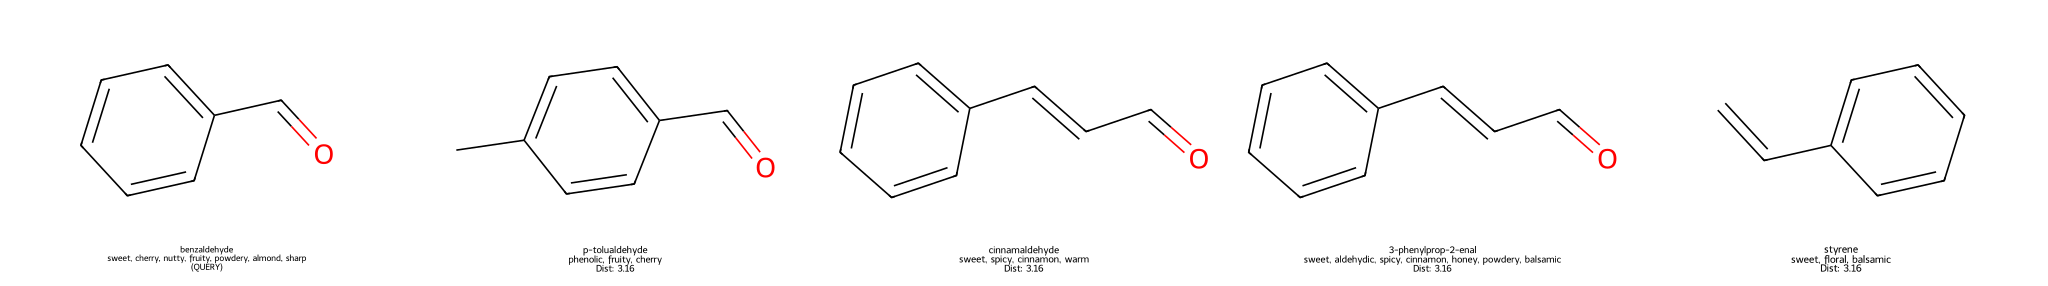

QUERY: benzaldehyde | C1=CC=C(C=C1)C=O
Zapachy: sweet, cherry, nutty, fruity, powdery, almond, sharp

Najbliżsi sąsiedzi (Morgan):
- p-tolualdehyde | CC1=CC=C(C=C1)C=O
  Zapachy: phenolic, fruity, cherry | Odległość: 3.16
- cinnamaldehyde | C1=CC=C(C=C1)/C=C/C=O
  Zapachy: sweet, spicy, cinnamon, warm | Odległość: 3.16
- 3-phenylprop-2-enal | C1=CC=C(C=C1)C=CC=O
  Zapachy: sweet, aldehydic, spicy, cinnamon, honey, powdery, balsamic | Odległość: 3.16
- styrene | C=CC1=CC=CC=C1
  Zapachy: sweet, floral, balsamic | Odległość: 3.16


In [75]:
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display
from sklearn.neighbors import NearestNeighbors

def show_query_and_neighbors(
    query_name=None,
    query_idx=None,
    X=None,  # cechy, np. feature_sets['Morgan']
    df=None, # oryginalny DataFrame
    n_neighbors=4,
    feature_type='Morgan'
):
    assert X is not None and df is not None, "Podaj X i df!"
    # Znajdź indeks jeśli podano nazwę
    if query_idx is None:
        if query_name is not None:
            query_idx = df.index[df['name'] == query_name].tolist()[0]
        else:
            raise ValueError("Podaj query_name lub query_idx!")
    # KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    dists, indices = knn.kneighbors([X[query_idx]])
    # Pierwszy to zawsze sama cząsteczka
    neighbor_indices = indices[0][1:]
    neighbor_dists = dists[0][1:]

    # Przygotuj listę mols i legend
    mols = []
    legends = []

    # Najpierw cząsteczka zapytania
    query_row = df.iloc[query_idx]
    mols.append(query_row['mol'])
    legends.append(f"{query_row['name']}\n{', '.join(query_row['Labels'])}\n(QUERY)")

    # Potem sąsiedzi
    for idx, dist in zip(neighbor_indices, neighbor_dists):
        row = df.iloc[idx]
        mols.append(row['mol'])
        legends.append(f"{row['name']}\n{', '.join(row['Labels'])}\nDist: {dist:.2f}")

    # Wyświetl siatkę obrazków
    img = MolsToGridImage(
        mols,
        legends=legends,
        molsPerRow=5,
        subImgSize=(500, 350),
        useSVG=True
    )
    display(img)
    print(f"QUERY: {query_row['name']} | {query_row['IsomericSMILES']}")
    print(f"Zapachy: {', '.join(query_row['Labels'])}")
    print(f"\nNajbliżsi sąsiedzi ({feature_type}):")
    for idx, dist in zip(neighbor_indices, neighbor_dists):
        row = df.iloc[idx]
        print(f"- {row['name']} | {row['IsomericSMILES']}\n  Zapachy: {', '.join(row['Labels'])} | Odległość: {dist:.2f}")

# Przykład użycia:
show_query_and_neighbors(query_name='benzaldehyde', X=feature_sets['Morgan'], df=df, n_neighbors=4, feature_type='Morgan')
# show_query_and_neighbors(query_idx=4, X=feature_sets['Mordred'], df=df, n_neighbors=4, feature_type='Mordred')
